100%|██████████| 3000/3000 [00:00<00:00, 4143.04it/s]


True params:         [30.  10.   0.3  1.   2. ]
Initial guess:       [25.   5.   0.1  0.   0. ]
Recovered params:    [24.96704864  5.7092625   0.29715203  0.58786797 -0.55552257]
Gradient at final:   [ 0.04818886 -2.0894322  -0.20230523  0.1916067   1.08315056]
Eigenvalues Hessian: [8.39052227e+01+0.j 2.48298699e+01+0.j 1.48798428e+00+0.j
 1.02393442e-02+0.j 3.56608230e-01+0.j]
Condition number:    8194.394177867838


/var/folders/6_/3st3g11j01127jc5bxl35pwc0000gn/T/ipykernel_26669/1437481587.py:135: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/6_/3st3g11j01127jc5bxl35pwc0000gn/T/ipykernel_26669/1437481587.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/6_/3st3g11j01127jc5bxl35pwc0000gn/T/ipykernel_26669/1437481587.py:198: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


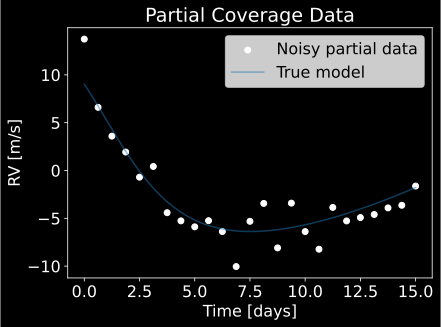

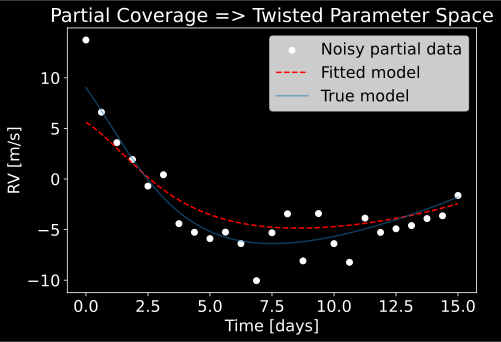

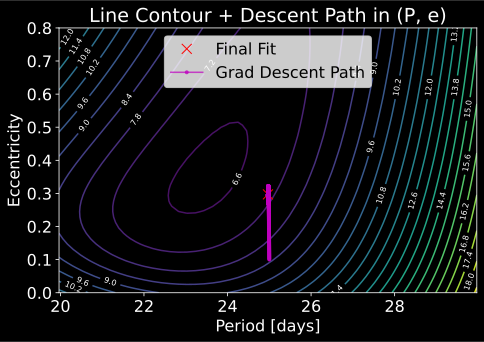

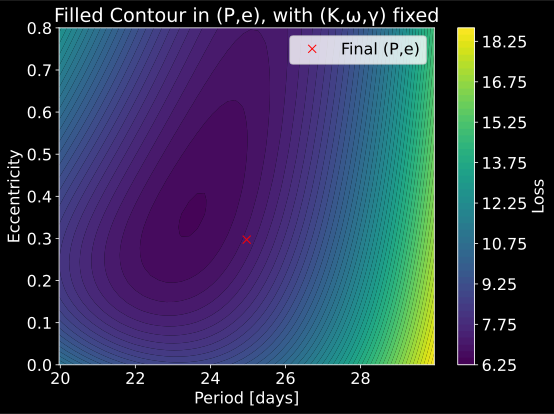

In [382]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#set the font size
matplotlib.rcParams.update({'font.size': 16})

jax.config.update("jax_enable_x64", True)

def kepler_eqn(M, e, tol=1e-10):
    """
    Solve Kepler's equation: M = E - e*sin(E) for E, given mean anomaly M.
    We'll do a simple Newton's method in JAX.
    """
    def newton_step(E, _):
        f = E - e*jnp.sin(E) - M
        fp = 1.0 - e*jnp.cos(E)
        return E - f/fp, 0

    E0 = M  # initial guess
    E, _ = jax.lax.scan(newton_step, E0, xs=None, length=100)
    return E

def true_anomaly(M, e):
    E = kepler_eqn(M, e)
    nu = 2.0 * jnp.arctan(
        jnp.sqrt((1.0 + e)/(1.0 - e)) * jnp.tan(0.5 * E)
    )
    return nu

def rv_model(t, params):
    """
    Single-planet RV model, ignoring small relativistic effects.
    params = (P, K, e, omega, gamma)
    """
    P, K, e, omega, gamma = params
    n = 2.0 * jnp.pi / P
    M_t = n * t
    nu_t = true_anomaly(M_t, e)
    rv = gamma + K * (jnp.cos(nu_t + omega) + e*jnp.cos(omega))
    return rv

def generate_synthetic_data(params_true, t_array, noise_std=2.0):
    key = jax.random.PRNGKey(42)
    rv_clean = rv_model(t_array, params_true)
    noise = noise_std * jax.random.normal(key, shape=t_array.shape)
    return rv_clean + noise

def rv_loss(params, t_array, rv_obs):
    rv_pred = rv_model(t_array, params)
    return jnp.mean((rv_pred - rv_obs)**2)

def set_bkgs_black(fig, ax):
    """Make figure/axes background black with white labeling."""
    fig.patch.set_facecolor('black')
    ax.patch.set_facecolor('black')
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')
    return fig, ax

grad_loss = jax.jit(jax.grad(rv_loss, argnums=0))
hess_loss = jax.hessian(rv_loss, argnums=0)

def demo_partial_coverage_with_path():
    # --- Generate partial coverage data
    params_true = jnp.array([30.0, 10.0, 0.3, 1.0, 2.0])  # (P, K, e, omega, gamma)
    max_obs = 15
    plot_str = ''
    # t_data = jnp.linspace(0, 15, 25)
    t_data = jnp.linspace(0,max_obs, 25)
    rv_obs = generate_synthetic_data(params_true, t_data, noise_std=2.0)
    t_dense = jnp.linspace(0, max_obs, 200)
    rv_true = rv_model(t_dense, params_true)

    # Plot partial coverage data only
    fig, ax = plt.subplots()
    fig, ax = set_bkgs_black(fig, ax)
    ax.scatter(t_data, rv_obs, color='white', label='Noisy partial data')
    ax.plot(t_dense, rv_true, 'C0', alpha=0.5, label='True model')
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('RV [m/s]')
    ax.set_title('Partial Coverage Data')
    ax.legend()
    plt.tight_layout()
    fig.savefig(f'partial_coverage_dataonly{plot_str}.png')
    
    # --- Gradient descent to fit
    params_init = jnp.array([25.0, 5.0, 0.1, 0.0, 0.0])
    lr = 1e-4
    steps = 3000
    params = params_init
    param_history = [params_init]

    import tqdm
    for _ in tqdm.tqdm(range(steps)):
        g = grad_loss(params, t_data, rv_obs)
        params = params - lr*g
        param_history.append(params)
    
    param_history = jnp.array(param_history)
    grad_final = grad_loss(params, t_data, rv_obs)
    hess_final = hess_loss(params, t_data, rv_obs)
    eigvals, _ = jnp.linalg.eig(hess_final)

    print("True params:        ", params_true)
    print("Initial guess:      ", params_init)
    print("Recovered params:   ", params)
    print("Gradient at final:  ", grad_final)
    print("Eigenvalues Hessian:", eigvals)
    print("Condition number:   ", jnp.abs(eigvals.max()/eigvals.min()))

    # --- Plot final fit
    rv_fit = rv_model(t_dense, params)
    rv_true = rv_model(t_dense, params_true)
    
    fig, ax = plt.subplots(figsize=(7,5))
    fig, ax = set_bkgs_black(fig, ax)
    ax.scatter(t_data, rv_obs, color='white', label='Noisy partial data')
    ax.plot(t_dense, rv_fit, 'r--', label='Fitted model')
    ax.plot(t_dense, rv_true, 'C0', alpha=0.5, label='True model')
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('RV [m/s]')
    ax.legend()
    ax.set_title('Partial Coverage => Twisted Parameter Space')
    plt.tight_layout()
    fig.savefig(f'partial_coverage{plot_str}.png')
    fig.show()

    # --- 2D slice in (P, e) around final solution
    # Plot the loss plus the path of gradient updates
    P_vals = jnp.linspace(params[0]-5, params[0]+5, 50)
    e_vals = jnp.linspace(0.0, 0.8, 50)
    PP, EE = jnp.meshgrid(P_vals, e_vals)

    def batched_loss(P_in, e_in):
        new_params = jnp.array([P_in, params[1], e_in, params[3], params[4]])
        return rv_loss(new_params, t_data, rv_obs)

    Z = jax.vmap(
            lambda p: jax.vmap(
                lambda evar: batched_loss(p, evar)
            )(e_vals)
         )(P_vals)
    
    # Plot line-contour with path
    fig, ax = plt.subplots(figsize=(7,5))
    fig, ax = set_bkgs_black(fig, ax)
    cs = ax.contour(P_vals, e_vals, Z, levels=20, cmap='viridis')
    ax.clabel(cs, inline=1, fontsize=8, colors='white')
    ax.plot(params[0], params[2], 'rx', label='Final Fit', markersize=10)
    ax.plot(param_history[:,0], param_history[:,2], 'mo-', ms=3, alpha=0.7, 
            label='Grad Descent Path')
    ax.set_title('Line Contour + Descent Path in (P, e)')
    ax.set_xlabel('Period [days]')
    ax.set_ylabel('Eccentricity')
    ax.legend()
    plt.tight_layout()
    fig.savefig(f'partial_path{plot_str}.png')
    fig.show()

    # --- Now do a *solid* colored contour (contourf) for a more detailed map
    # We'll also do a colorbar to show the scale
    Z2 = jax.vmap(
            lambda p: jax.vmap(
                lambda evar: batched_loss(p, evar)
            )(e_vals)
        )(P_vals)

    fig, ax = plt.subplots(figsize=(8,6))
    fig, ax = set_bkgs_black(fig, ax)
    # contourf for filled contour
    c_levels = 50  # more levels => smoother gradient
    cf = ax.contourf(P_vals, e_vals, Z2, levels=c_levels, cmap='viridis')
    # optional colorbar
    cbar = plt.colorbar(cf, ax=ax)
    cbar.ax.yaxis.set_tick_params(color='white')
    cbar.outline.set_edgecolor('white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    cbar.set_label("Loss", color='white')

    # Mark the final fit point
    ax.plot(params[0], params[2], 'rx', ms=8, label='Final (P,e)')

    ax.set_xlabel('Period [days]')
    ax.set_ylabel('Eccentricity')
    ax.set_title('Filled Contour in (P,e), with (K,ω,γ) fixed')
    ax.legend()
    plt.tight_layout()
    fig.savefig(f'partial_contour_filled_{plot_str}.png')
    fig.show()


demo_partial_coverage_with_path()

In [395]:
#Evaluating the gradient and hessian at the initial parameters, with no noise

params_true = jnp.array([30.0, 10.0, 0.3, 1.0, 2.0])  # (P, K, e, omega, gamma)
params_init = jnp.array([29.0, 5.0, 0.1, 0.0, 0.0]) #initial guess
max_obs = 25
n_obs = 10000

t_data = jnp.linspace(0, max_obs, n_obs)
rv_obs = generate_synthetic_data(params_true, t_data, noise_std=0)
t_dense = jnp.linspace(0, max_obs, n_obs*8)
rv_true = rv_model(t_dense, params_true)

#evaluate the loss at the initial parameters and the jacobian
loss_init = rv_loss(params_init, t_data, rv_obs)
grad_init = grad_loss(params_init, t_data, rv_obs)
hessian = hess_loss(params_init, t_data, rv_obs)
eigval_hess,eigvec_hess = jnp.linalg.eigh(hessian)


In [396]:
eigval_hess

Array([-3.32171274, -2.11277983, -0.22619609,  2.12449517, 21.15726076],      dtype=float64)

In [385]:
update_mag = jnp.logspace(-9,2,100)
losse_idx = []
losses_idx_so = []
rv_obs_init = rv_model(t_data, params_init)
loss_init = rv_loss(params_init, t_data, rv_obs)
for idx in range(5):
    losses = []
    losses_so = []
    for mag in tqdm.tqdm(update_mag):
        # print(params_true + mag * eigvec_hess[:,idx])
        param_update = params_init + mag * eigvec_hess[:,idx]
        param_update = param_update.at[2].set(jnp.clip(param_update[2], 0, 0.99))
        loss = jax.jit(rv_loss)(param_update, t_data, rv_obs)
        grad_dot_ei = jnp.dot(grad_init, eigvec_hess[:, idx]) 
        lambda_i = eigval_hess[idx]
        predict_loss = (
            loss_init
            + mag * grad_dot_ei
            # + 0.5 * (mag**2) * lambda_i
        )
        losses.append(jnp.abs(loss - predict_loss))
        predict_loss_so = (
            loss_init
            + mag * grad_dot_ei
            + 0.5 * (mag**2) * lambda_i
        )
        losses_so.append(jnp.abs(loss - predict_loss_so))
    losse_idx.append(losses)
    losses_idx_so.append(losses_so)


100%|██████████| 100/100 [00:00<00:00, 420.86it/s]


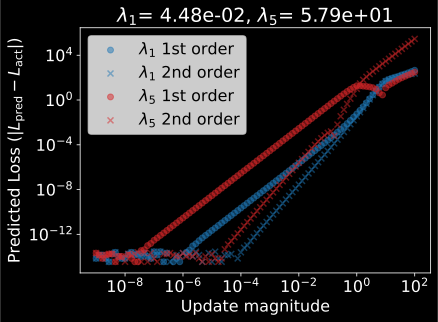

In [380]:
plt.close('all')
# colors = [f'C{i}' for i in range(5)]
colors = ['C0', 'C3', 'C3', 'C3', 'C3']
idxs = [0, 4]
fig, ax = plt.subplots()
fig, ax = set_bkgs_black(fig, ax)
for idx in idxs:
    ax.scatter(update_mag, losse_idx[idx], label=f'Direction $\\lambda_{idx+1}$', alpha=0.5, color=colors[idx])
    ax.scatter(update_mag, losses_idx_so[idx], alpha=0.5, marker='x', color=colors[idx])
ax.set_xlabel('Update magnitude')
ax.set_ylabel(f'Predicted Loss ($|L_\\text{{pred}} - L_\\text{{act}}|$)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend([f'$\\lambda_1$ 1st order', f'$\\lambda_1$ 2nd order', f'$\\lambda_5$ 1st order', f'$\\lambda_5$ 2nd order'])
ax.set_title(f'$\\lambda_1$= {eigval_hess[0]:.2e}, $\\lambda_5$= {eigval_hess[4]:.2e}')
plt.tight_layout()
fig.savefig(f'loss_predictmore_param.png')